In [92]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

In [93]:
FIL = float

with pm.Model() as model:

    AVERAGE_PAYMENT: FIL = 1.0
    STD_PAYMENT: FIL = 1.0

    # Observables
    p = pm.Gamma('payment', mu=AVERAGE_PAYMENT, sd=STD_PAYMENT)
    P_r_d2bar = pm.Uniform('P_r_d2bar', lower=0.5, upper=1)
    P_r_d2 = pm.Uniform('P_r_d2', lower=P_r_d2bar, upper=1)
    P_r_d3 = pm.Uniform('P_r_d3', lower=0.0, upper=1.0)
    P_d4_d2 = pm.Beta('P_d4_d2', mu=0.01, sd=0.01)

    # Inobservables
    N_a = pm.Gamma('N_a', mu=P_d4_d2, sd=0.005)
    alpha = pm.Uniform('alpha', lower=0.01, upper=2)

    # Parameters
    m_c = pm.Uniform('m_c', lower=0, upper=2)
    m_s = pm.Uniform('m_s', lower=0, upper=2_000)

   # Auxiliary Variables
    pi_r_C = pm.Deterministic('pi_r_C', p / alpha)
    P_d4_d3 = pm.Uniform('P_d4_d3', lower=P_r_d3, upper=1)
    P_r_d3bar = pm.Uniform('P_r_d3bar', lower=0.0, upper=P_r_d3)
    P_d4bar_d2 = pm.Deterministic('P_d4bar_d2', 1 - P_d4_d2)
    d_r = P_r_d2 - P_r_d2bar
    eq_mc = pm.Deterministic('eq_mc', (d_r + alpha + 2 * P_d4_d2 - 1) / N_a)
    eq_ms = pm.Deterministic('eq_ms', 1 / P_d4_d2 - 1)

    # Payoffs & Decisions
    pi_d1_C = pi_r_C * P_r_d2 + p * (2 * P_d4_d2 - N_a * m_c - 1)
    pi_d1_C_bar = pi_r_C * P_r_d2bar
    U_d1 = pm.Deterministic('U_d1', pi_d1_C - pi_d1_C_bar)
    d1 = pm.Deterministic('d1', U_d1 > 0)

    pi_d2_P = p * (P_d4bar_d2 - m_s * P_d4_d2)
    pi_d2_P_bar = 0.0
    U_d2 = pi_d2_P - pi_d2_P_bar
    d2 = pm.Deterministic('d2', d1 & (U_d2 > 0))

    pi_d3_C = pi_r_C * P_r_d3 + p * (P_d4_d3 - m_c)
    pi_d3_C_bar = pi_r_C * P_r_d3bar
    U_d3 = pi_d3_C - pi_d3_C_bar
    d3 = pm.Deterministic('d3', d2 & (U_d3 > 0))

    pi_d4_R = pm.Bernoulli('pi_d4_R', p=1-P_r_d3)
    pi_d4_R_bar = pm.Deterministic('pi_d4_R_bar', 0 if pi_d4_R == 1 else 0)
    U_d4 = pi_d4_R - pi_d4_R_bar
    d4 = pm.Deterministic('d4', d3 & (U_d4 > 0))

    # Priors for unknown model parameters
    trace = pm.sample(draws=20_000,
                      chains=4,
                      tune=3_000,
                      nuts={'target_accept':0.98},
                      return_inferencedata=True)


AttributeError: 'int' object has no attribute 'copy'

In [ ]:
print(trace.posterior.d1.sum())
print(trace.posterior.d2.sum())
print(trace.posterior.d3.sum())
print(trace.posterior.d4.sum())


<xarray.DataArray 'd1' ()>
array(2159)
<xarray.DataArray 'd2' ()>
array(385)
<xarray.DataArray 'd3' ()>
array(306)
<xarray.DataArray 'd4' ()>
array(138)


In [94]:
print(np.percentile(trace.posterior.eq_mc, [2.5, 50, 97.5]))
print(np.percentile(trace.posterior.eq_ms, [2.5, 50, 97.5]))

[-5.11159523e+24  1.97459893e+01  2.75979998e+37]
[  27.54855247  148.34843245 2818.64929878]


In [95]:

df = trace.posterior.to_dataframe()

metric_0 = df.d1
metric_1 = df.d2[metric_0 == True]
metric_2 = (df.P_r_d2 / df.P_r_d2bar)[metric_0 == True]
#metric_3 = df.payment * (1 - df.P_r_d2) * df.P_d4_d2 / df.pi_r_C
#metric_4 = df.pi_d4_R_bar
metric_5 = df.pi_d4_R

In [96]:
metric_1

chain  draw
0      1       False
       50      False
       52      False
       53       True
       54       True
               ...  
3      9808    False
       9818    False
       9874     True
       9960     True
       9973    False
Name: d2, Length: 2159, dtype: bool

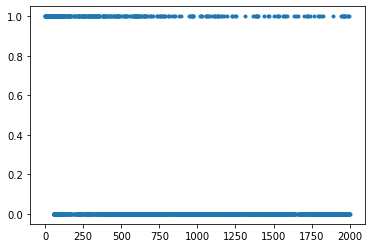

In [97]:
inds = trace.posterior.d1.values == 1
x = trace.posterior.m_s.values[inds].flatten()
y = trace.posterior.d2.values[inds].flatten()

plt.plot(x, y, '.')
plt.show()

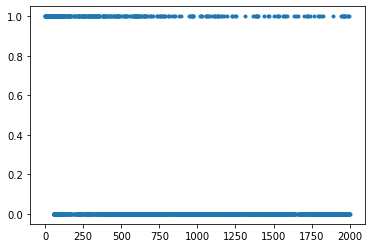

In [98]:
inds = trace.posterior.d1.values == 1
x = trace.posterior.m_s.values[inds].flatten()
y = trace.posterior.d2.values[inds].flatten()

plt.plot(x, y, '.')
plt.show()

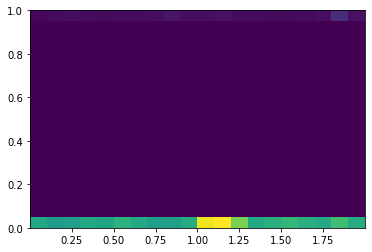

In [99]:
x = trace.posterior.m_c.values.flatten()
y = trace.posterior.d1.values.flatten()

plt.hist2d(x, y, bins=20)
plt.show()

In [100]:
def summarize_trace(trace):
    print("-- median --")
    print(trace.posterior.median())
    print("-- std --")
    print(trace.posterior.std())
    print("-- std per median -- ")
    print(trace.posterior.std() / trace.posterior.median())
    pm.plot_trace(trace)
    plt.show()

    bfmi = np.max(pm.stats.bfmi(trace))
    max_gr = max(np.max(gr_stats) for gr_stats in pm.stats.rhat(trace).values()).values
    (
        pm.plot_energy(trace, legend=False, figsize=(6, 4)).set_title(
            f"BFMI = {bfmi :.2e}\nGelman-Rubin = {max_gr :.2e}"
        )
    )
    plt.show()

    pm.plot_posterior(trace)
    plt.show()
    
    pd.plotting.scatter_matrix(trace.posterior.to_dataframe(), figsize=(20, 20))
    plt.show()


-- median --
<xarray.Dataset>
Dimensions:    ()
Data variables: (12/19)
    pi_d4_R    float64 0.0
    payment    float64 0.6162
    P_r_d2bar  float64 0.7132
    P_r_d2     float64 0.8912
    P_r_d3     float64 0.5629
    P_d4_d2    float64 0.006696
    ...         ...
    eq_ms      float64 148.3
    U_d1       float64 -0.4618
    d1         float64 0.0
    d2         float64 0.0
    d3         float64 0.0
    d4         float64 0.0
-- std --
<xarray.Dataset>
Dimensions:    ()
Data variables: (12/19)
    pi_d4_R    float64 0.4977
    payment    float64 0.9471
    P_r_d2bar  float64 0.1439
    P_r_d2     float64 0.1057
    P_r_d3     float64 0.3006
    P_d4_d2    float64 0.01
    ...         ...
    eq_ms      float64 966.9
    U_d1       float64 1.422
    d1         float64 0.226
    d2         float64 0.09763
    d3         float64 0.08713
    d4         float64 0.05864
-- std per median -- 
<xarray.Dataset>
Dimensions:    ()
Data variables: (12/19)
    pi_d4_R    float64 inf
    pa

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning:

overflow encountered in square

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning:

overflow encountered in double_scalars

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning:

invalid value encountered in double_scalars

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils.py:770: UserWarning:

Something failed when estimating the bandwidth. Please check your data

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning:

divide by zero encountered in true_divide

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning:

invalid value encountered in true_divide

/opt/homebrew/Caskroom/mini

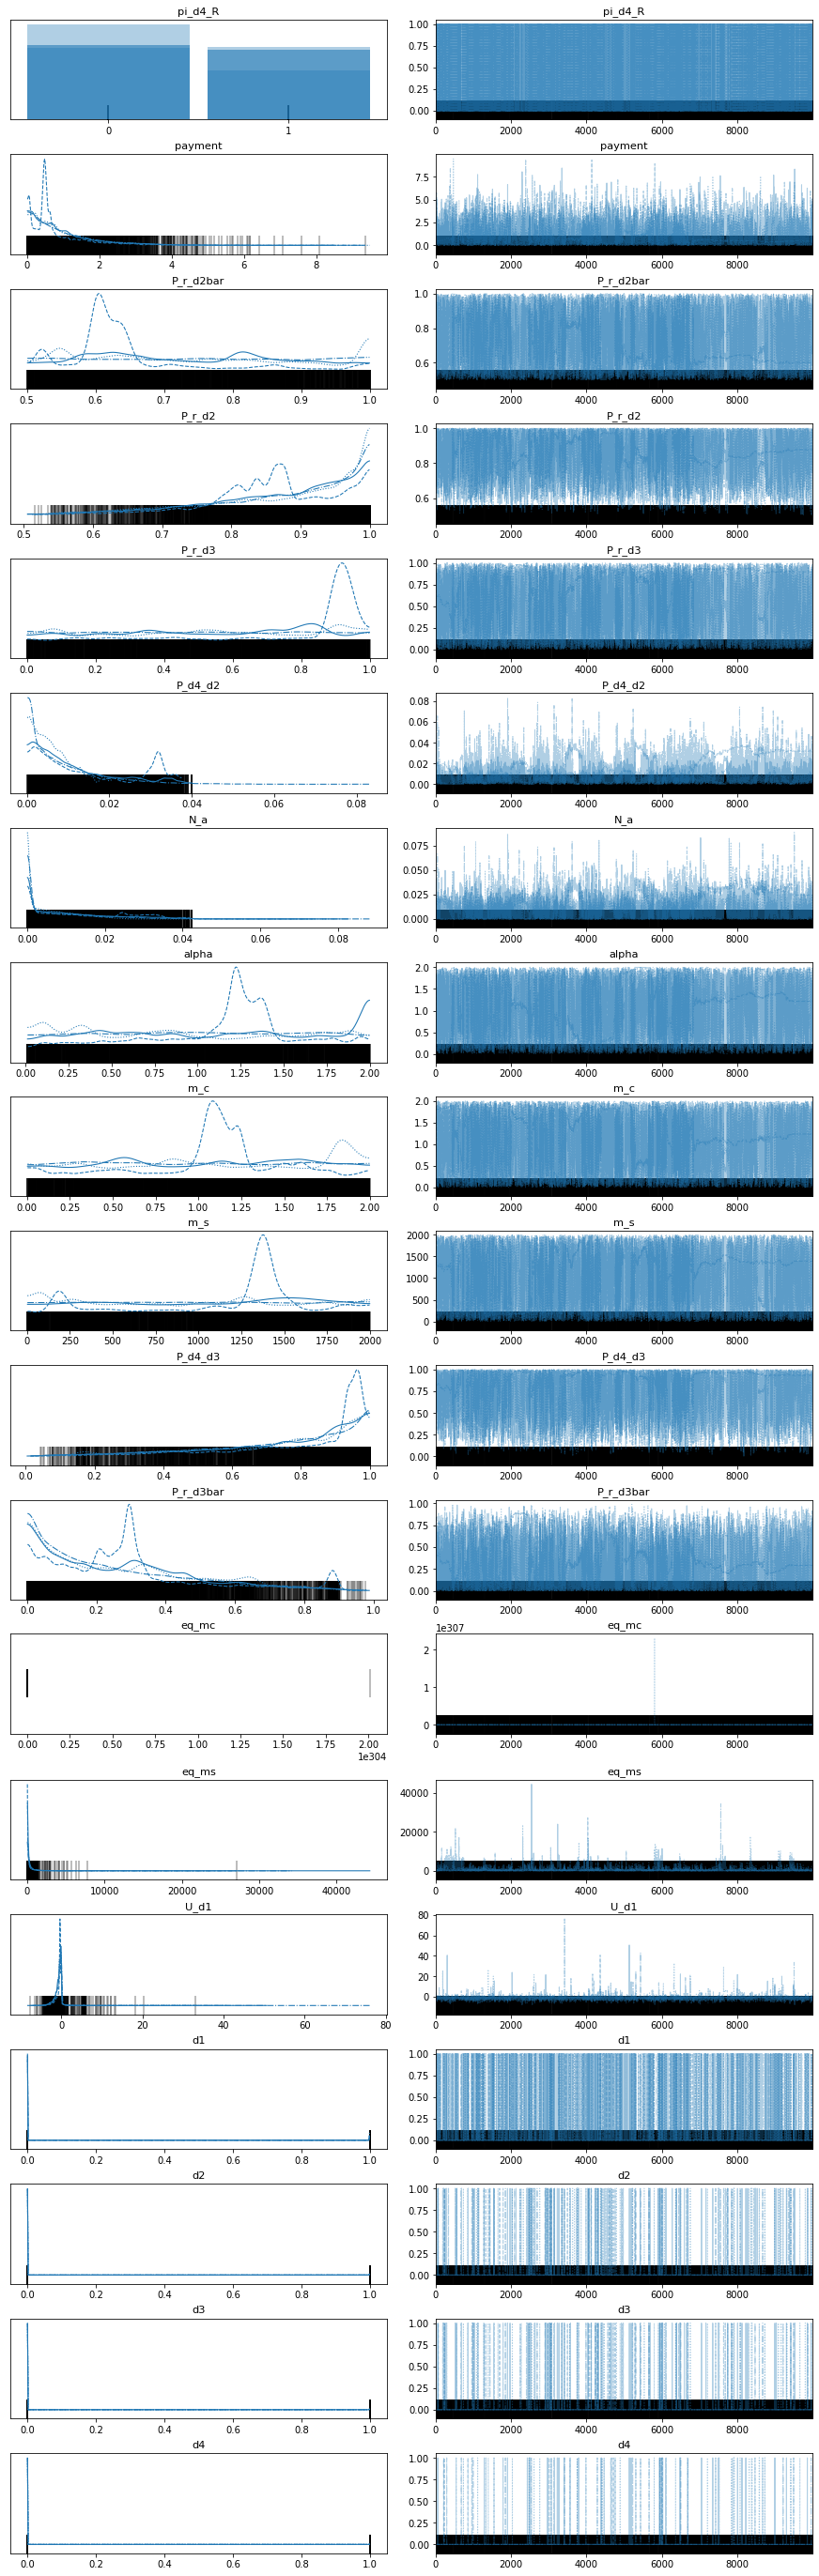

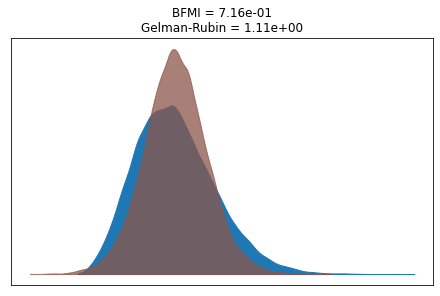

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning:

overflow encountered in square

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning:

overflow encountered in double_scalars

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning:

invalid value encountered in double_scalars

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils.py:770: UserWarning:

Something failed when estimating the bandwidth. Please check your data

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning:

divide by zero encountered in true_divide

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning:

invalid value encountered in true_divide

/opt/homebrew/Caskroom/mini

ValueError: cannot convert float NaN to integer

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning:

constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.



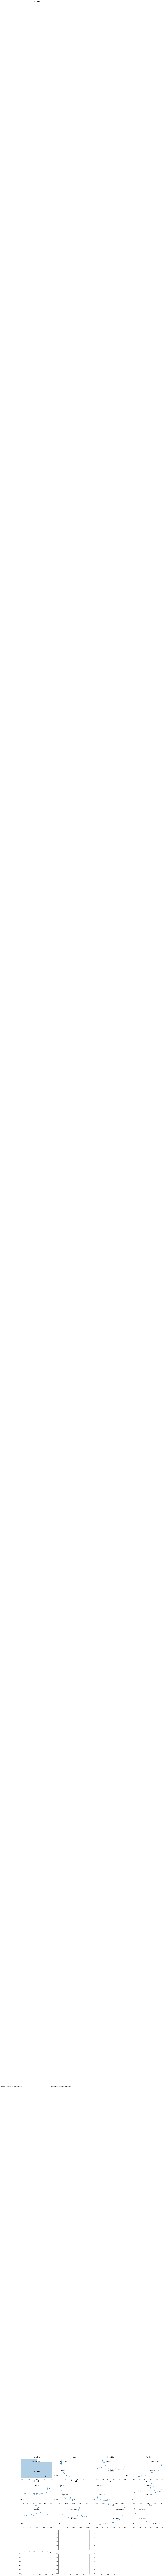

In [101]:
summarize_trace(trace)